In [18]:
import keras
from keras.preprocessing.sequence import pad_sequences
from keras.layers import Input, Dense, LSTM, Embedding, GRU
from keras.layers import Dropout, Activation, Bidirectional, GlobalMaxPool1D
from keras.models import Model
from keras import initializers, regularizers, constraints, optimizers, layers
from keras.preprocessing import text, sequence
from keras.callbacks import ModelCheckpoint
from keras.callbacks import EarlyStopping
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
!matplotlib inline
np.random.seed(0)

'matplotlib' is not recognized as an internal or external command,
operable program or batch file.


In [2]:
episodes=pd.read_csv('episodes_cleaned.csv',index_col='Unnamed: 0')
scripts=pd.read_csv('scripts_cleaned.csv',index_col='Unnamed: 0')

In [3]:
episodes['Larry']=0
for ep in episodes.iterrows():
    names=(ep[1][4].replace(' and ',',').split(','))
    for name in names:
        if 'Larry David' in name:
            episodes['Larry'][ep[0]]=1
larry_eps=list(episodes.loc[episodes.Larry==1]['SEID'])
    

C:\kosta\Anaconda3\lib\site-packages\ipykernel_launcher.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  


In [4]:
episodes.Larry.sum()

58

In [5]:
scripts['Larry']=0
for ep in larry_eps:
    scripts.loc[scripts['SEID']==ep,'Larry']=1
scripts.head()

,Character,Dialogue,EpisodeNo,SEID,Season,character_stripped,Larry
0,jerry,do you know what this is all about? do you kno...,0.0,S01E00,1.0,jerry,1
1,jerry,"(pointing at georges shirt) see, to me, that b...",0.0,S01E00,1.0,jerry,1
2,george,are you through?,0.0,S01E00,1.0,george,1
3,jerry,"you do of course try on, when you buy?",0.0,S01E00,1.0,jerry,1
4,george,"yes, it was purple, i liked it, i dont actuall...",0.0,S01E00,1.0,george,1


In [6]:
tokenizer = text.Tokenizer(num_words=20000)
tokenizer.fit_on_texts(list(scripts['Dialogue'].values))
list_tokenized_train = tokenizer.texts_to_sequences(scripts.Dialogue.values)
X_t = pad_sequences(list_tokenized_train,maxlen=100)
y=scripts.Larry.values

In [14]:
from imblearn.over_sampling import RandomOverSampler, SMOTE
X_resampled, y_resampled = SMOTE().fit_sample(X_t, y) 

In [15]:
X_r_train, X_r_test, y_r_train, y_r_test = train_test_split(X_resampled,y_resampled)

In [19]:
embedding_size = 128
input_ = Input(shape=(100,))
x = Embedding(20000,embedding_size)(input_)
x = Bidirectional(GRU(200,return_sequences=True))(x)
x = GlobalMaxPool1D()(x)
x = Dropout(0.5)(x)
x = Dense(200,activation='relu')(x)
x = Dropout(0.5)(x)
x = Dense(100,activation='relu')(x)
x = Dropout(0.5)(x)
x = Dense(1,activation='sigmoid')(x)

model2 = Model(inputs=input_,outputs=x)
model2.compile(loss='binary_crossentropy',optimizer='adam',metrics=['accuracy'])

checkpoints_path = 'weights_base.best.hdf5'
checkpoint = [ModelCheckpoint(checkpoints_path, monitor='val_loss', verbose=1, save_best_only=True, mode='min')]

history2=model2.fit(X_r_train,y_r_train,batch_size=32,epochs=5,validation_split=0.1, callbacks=checkpoint)

Train on 48714 samples, validate on 5413 samples
Epoch 1/5
48714/48714 [==============================] - 844s 17ms/step - loss: 0.6729 - acc: 0.5690 - val_loss: 0.6284 - val_acc: 0.6519

Epoch 00001: val_loss improved from inf to 0.62844, saving model to weights_base.best.hdf5
Epoch 2/5
48714/48714 [==============================] - 853s 18ms/step - loss: 0.5469 - acc: 0.7137 - val_loss: 0.5649 - val_acc: 0.6841

Epoch 00002: val_loss improved from 0.62844 to 0.56493, saving model to weights_base.best.hdf5
Epoch 3/5
48714/48714 [==============================] - 865s 18ms/step - loss: 0.4405 - acc: 0.7728 - val_loss: 0.6217 - val_acc: 0.6767

Epoch 00003: val_loss did not improve from 0.56493
Epoch 4/5
48714/48714 [==============================] - 849s 17ms/step - loss: 0.3726 - acc: 0.8045 - val_loss: 0.6861 - val_acc: 0.6758

Epoch 00004: val_loss did not improve from 0.56493
Epoch 5/5
48714/48714 [==============================] - 848s 17ms/step - loss: 0.3303 - acc: 0.8237 - val_

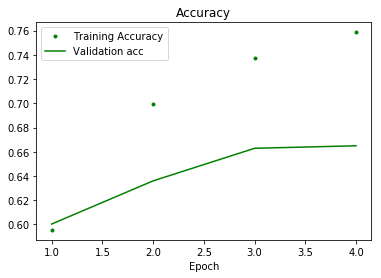

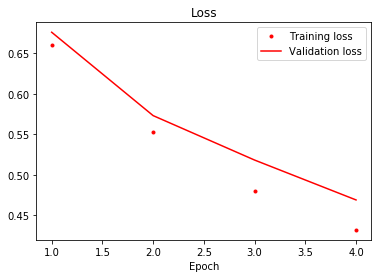

In [10]:
train_acc = history2.history['acc']
val_acc = history2.history['val_acc']
train_loss = history2.history['loss']
val_loss = history2.history['val_loss']
epch = range(1, len(train_acc) + 1)
plt.plot(epch, train_acc, 'g.', label='Training Accuracy')
plt.plot(epch, val_acc, 'g', label='Validation acc')
plt.title('Accuracy')
plt.legend()
plt.xlabel('Epoch')
plt.figure()
plt.plot(epch, train_loss, 'r.', label='Training loss')
plt.plot(epch, val_loss, 'r', label='Validation loss')
plt.title('Loss')
plt.xlabel('Epoch')
plt.legend()
plt.show()

In [ ]:
model2.evaluate(X_r_test,y_r_test)